In [41]:
# default_exp data.procs

In [42]:
# hide
import sys

sys.path.append("..")
import pandas as pd

In [43]:
# hide
from nbdev.showdoc import *

# Data.Procs

### CatProc

In [44]:
# export
from fastseq.data.external import *
from fastseq.data.load import *
from fastseq.data.core import *
from fastseq.core import *
from fastcore.all import *
from fastcore.imports import *
from fastai2.basics import *
from fastai2.data.transforms import *
from fastai2.tabular.core import *
from typing import List
import orjson

In [45]:
# export
class CatProc():
    def __init__(self, path, num_of_workers = None, vocab = None, o2i = None):
        store_attr(self, 'path,num_of_workers,vocab,o2i')
        self.init()
        
    def init(self, hard = False):     
        if (self.vocab is None and self.o2i is None) or hard:
            self.vocab, self.o2i = make_vocab(self.path)        
        self.meta = get_meta(self.path)
        self.f = CatMultiTfm(vocab = self.vocab, o2i = self.o2i)
        print(self.vocab)
        
    def __call__(self, files:List[Path]):  
        self.init(True)        
        if self.num_of_workers >1:
            return multithread_f(self._setup, files, self.num_of_workers)
        else:
            r = []
            for f in files:
                r.append(self._setup(f))
            return r
    
    def _setup(self, f:Path):   
        ts = get_ts_datapoint(f)
        tsm = json2TSMulti(ts, 0, self.meta['col_names']['ts_con_names'][0], ts['_length']-1, 1, self.meta)
        tsm = self.f(tsm)
        
#         assert len(tsm[2]) == len(ts['ts_cat']), f"{ts['ts_cat'].keys()} == {tsm[2].shape}"

        for i, cat in enumerate(ts['ts_cat']):
            test_eq(len(tsm[2][i]), len(ts['ts_cat'][cat]))
            ts['ts_cat'][cat] = [o.item() for o in tsm[2][i]]
        for i, cat in enumerate(ts['cat']):
            ts['cat'][cat] = tsm[3][i].item()
        open(f,'wb').write(orjson.dumps(dict(ts)))
        return f
        

In [46]:
# %%time
path = Path('../data/test_data')
horizon,lookback = 7, 14
del_create([2000]*10, path = path)

fs = get_files(path, extensions='.json', folders = False)

proc = CatProc(path, num_of_workers = 1)
r = proc(fs)

{'cat_0': (#2) ['a','b'], 'cat_1': (#2) ['adam','rdam'], 'cat_ts_0': (#2) ['a','b'], 'cat_ts_1': (#2) ['david','john']}
{'cat_0': (#2) ['a','b'], 'cat_1': (#2) ['adam','rdam'], 'cat_ts_0': (#2) ['a','b'], 'cat_ts_1': (#2) ['david','john']}


In [47]:
for f in fs:
    ts = get_ts_datapoint(f)
    for cat in set(unpack_list([v for k,v in ts['ts_cat'].items()])):
        test_eq(type(cat), int)
        
    for cat in set(unpack_list([v for k,v in ts['cat'].items()])):
        test_eq(type(cat), int)

In [48]:
%%time
# hide
path = Path('../data/test_data')
horizon,lookback = 7, 14
del_create([2000]*10, path = path)

fs = get_files(path, extensions='.json', folders = False)

proc = CatProc(path, num_of_workers = 8)
r = proc(fs)

{'cat_0': (#2) ['a','b'], 'cat_1': (#2) ['adam','rdam'], 'cat_ts_0': (#2) ['a','b'], 'cat_ts_1': (#2) ['david','john']}
{'cat_0': (#2) ['a','b'], 'cat_1': (#2) ['adam','rdam'], 'cat_ts_0': (#2) ['a','b'], 'cat_ts_1': (#2) ['david','john']}
CPU times: user 1.03 s, sys: 175 ms, total: 1.21 s
Wall time: 1.01 s


### DateFeatures

In [49]:
# export
from fastai2.tabular import *

In [50]:
# export
class DateProc:
    def __init__(
        self,
        path: Path,
        field_name: str,
        num_of_workers=None,
        con_cols=["Year", "Day", "Dayofweek", "Dayofyear", "Elapsed"],
        cat_cols=["Year", "Day", "Dayofweek",'Is_month_end',
                  'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start',],
    ):
        self.path = path
        self.meta = get_meta(path)
        self.num_of_workers = num_of_workers
        self.field_name = field_name
        self.con_cols = con_cols
        self.cat_cols = cat_cols

    def __call__(self, files: List[Path]): 
        r = []
        _, ts = self._setup(files[0],with_ts=True)
        o = {}
        for k,v in ts.items():
            if k[0] is not '_':
                try:
                    o.update({col:python_type(o) for col, o in v.items()})
                except:
                    print(k,v)
                    assert False
        length, classes, col_names, names = reconize_cols(o)
        make_meta_file(self.path, classes = classes, col_names = col_names)
        self.meta = get_meta(self.path)
        
        for i,f in enumerate(files):
            r.append(self._setup(f))
        return r
    
        # return multithread_f(self._setup, files, self.num_of_workers)

    def _setup(self, f: Path, with_ts=False):
        ts = get_ts_datapoint(f)
        df = pd.DataFrame(ts["ts_cat"])
        df = add_datepart(df, self.field_name)

        ts["ts_cat"].update({k: list(v.astype(str)) for k, v in dict(df).items() if k in self.cat_cols})
        df[self.con_cols] = (df[self.con_cols] - df[self.con_cols].mean()) / (df[
            self.con_cols
        ].std() + 1e-7)
        ts["ts_con"].update( {
            k: list(v) for k, v in dict(df).items() if k in self.con_cols
        })
        open(f, "wb").write(orjson.dumps(dict(ts)))
        if with_ts:
            return f, ts
        return f


In [51]:
path = Path("../data/m5_tiny/rows")
new_path = Path('../data/m5_tiny/rows_date')
new_path.delete()


In [52]:
if not new_path.exists():new_path.mkdir()
for i,f in enumerate(path.glob('*.json')):
    f.copy(new_path / f.name)
    if i == 50:
        break
(path / '.ts_meta').copy(new_path / '.ts_meta')

fs = get_files(new_path, extensions=".json", folders=False)
print(get_ts_datapoint(fs[0])['ts_cat'].keys(), get_ts_datapoint(fs[0])['ts_cat'].keys() )

dict_keys(['weekday', 'd.1', 'date']) dict_keys(['weekday', 'd.1', 'date'])


In [53]:
proc = DateProc(new_path, "date", num_of_workers=1)
fs = proc(fs)

In [54]:
print('ts_cat',get_ts_datapoint(fs[0])['ts_cat'].keys())
print('ts_con',get_ts_datapoint(fs[0])['ts_con'].keys())
print('\nmeta')
print(get_meta(new_path))

ts_cat dict_keys(['weekday', 'd.1', 'date', 'Year', 'Day', 'Dayofweek', 'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start'])
ts_con dict_keys(['sales', 'snap_CA', 'prices', 'snap_TX', 'year', 'snap_WI', 'month', 'wm_yr_wk', 'wday', 'Year', 'Day', 'Dayofweek', 'Dayofyear', 'Elapsed'])

meta
classes:	{'Day': (#31) ['16','8','11','26','18','13','12','23','31','7'...], 'Dayofweek': (#7) ['2','0','4','3','5','6','1'], 'Is_month_end': (#2) ['False','True'], 'Is_month_start': (#2) ['False','True'], 'Is_quarter_end': (#2) ['False','True'], 'Is_quarter_start': (#2) ['False','True'], 'Is_year_end': (#2) ['False','True'], 'Is_year_start': (#2) ['False','True'], 'Year': (#6) ['2016','2013','2011','2012','2014','2015'], 'cat_id': (#3) ['FOODS','HOUSEHOLD','HOBBIES'], 'd.1': (#1969) ['d_1226','d_544','d_692','d_1493','d_794','d_1953','d_852','d_1443','d_476','d_58'...], 'date': (#1969) ['2011-09-06','2011-05-13','2014-03-12','2012-05-09','2011-10-1

In [55]:
get_ts_datapoint(fs[0])['ts_cat']
proc = CatProc(new_path, num_of_workers = 1)
r = proc(fs)

{'Day': (#31) ['1','10','11','12','13','14','15','16','17','18'...], 'Dayofweek': (#7) ['0','1','2','3','4','5','6'], 'Is_month_end': (#2) ['False','True'], 'Is_month_start': (#2) ['False','True'], 'Is_quarter_end': (#2) ['False','True'], 'Is_quarter_start': (#2) ['False','True'], 'Is_year_end': (#2) ['False','True'], 'Is_year_start': (#2) ['False','True'], 'Year': (#6) ['2011','2012','2013','2014','2015','2016'], 'cat_id': (#3) ['FOODS','HOBBIES','HOUSEHOLD'], 'd.1': (#1969) ['d_1','d_10','d_100','d_1000','d_1001','d_1002','d_1003','d_1004','d_1005','d_1006'...], 'date': (#1969) ['2011-01-29','2011-01-30','2011-01-31','2011-02-01','2011-02-02','2011-02-03','2011-02-04','2011-02-05','2011-02-06','2011-02-07'...], 'dept_id': (#7) ['FOODS_1','FOODS_2','FOODS_3','HOBBIES_1','HOBBIES_2','HOUSEHOLD_1','HOUSEHOLD_2'], 'id': (#30490) ['FOODS_1_001_CA_1_validation','FOODS_1_001_CA_2_validation','FOODS_1_001_CA_3_validation','FOODS_1_001_CA_4_validation','FOODS_1_001_TX_1_validation','FOODS_1_0

## M5 example

In [56]:
new_path.ls()

(#52) [Path('../data/m5_tiny/rows_date/FOODS_2_176_CA_1.json'),Path('../data/m5_tiny/rows_date/FOODS_2_164_TX_3.json'),Path('../data/m5_tiny/rows_date/FOODS_2_181_CA_4.json'),Path('../data/m5_tiny/rows_date/FOODS_2_145_CA_3.json'),Path('../data/m5_tiny/rows_date/FOODS_2_150_TX_3.json'),Path('../data/m5_tiny/rows_date/FOODS_2_141_CA_3.json'),Path('../data/m5_tiny/rows_date/HOUSEHOLD_2_193_WI_3.json'),Path('../data/m5_tiny/rows_date/FOODS_2_174_CA_1.json'),Path('../data/m5_tiny/rows_date/FOODS_2_124_CA_3.json'),Path('../data/m5_tiny/rows_date/FOODS_2_112_TX_3.json')...]

In [57]:
tmf = CatProc(new_path)


{'Day': (#31) ['1','10','11','12','13','14','15','16','17','18'...], 'Dayofweek': (#7) ['0','1','2','3','4','5','6'], 'Is_month_end': (#2) ['False','True'], 'Is_month_start': (#2) ['False','True'], 'Is_quarter_end': (#2) ['False','True'], 'Is_quarter_start': (#2) ['False','True'], 'Is_year_end': (#2) ['False','True'], 'Is_year_start': (#2) ['False','True'], 'Year': (#6) ['2011','2012','2013','2014','2015','2016'], 'cat_id': (#3) ['FOODS','HOBBIES','HOUSEHOLD'], 'd.1': (#1969) ['d_1','d_10','d_100','d_1000','d_1001','d_1002','d_1003','d_1004','d_1005','d_1006'...], 'date': (#1969) ['2011-01-29','2011-01-30','2011-01-31','2011-02-01','2011-02-02','2011-02-03','2011-02-04','2011-02-05','2011-02-06','2011-02-07'...], 'dept_id': (#7) ['FOODS_1','FOODS_2','FOODS_3','HOBBIES_1','HOBBIES_2','HOUSEHOLD_1','HOUSEHOLD_2'], 'id': (#30490) ['FOODS_1_001_CA_1_validation','FOODS_1_001_CA_2_validation','FOODS_1_001_CA_3_validation','FOODS_1_001_CA_4_validation','FOODS_1_001_TX_1_validation','FOODS_1_0

In [58]:
path = Path("../data/m5_tiny/rows")
new_path = Path('../data/m5_tiny/rows_date')
new_path.delete()


In [59]:
if not new_path.exists():new_path.mkdir()
for i,f in enumerate(path.glob('*.json')):
    f.copy(new_path / f.name)
    if i == 50:
        break
(path / '.ts_meta').copy(new_path / '.ts_meta')

fs = get_files(new_path, extensions=".json", folders=False)
print(get_ts_datapoint(fs[0])['ts_cat'].keys(), get_ts_datapoint(fs[0])['ts_cat'].keys() )

dict_keys(['weekday', 'd.1', 'date']) dict_keys(['weekday', 'd.1', 'date'])


{'cat_id': (#3) ['FOODS','HOBBIES','HOUSEHOLD'], 'd.1': (#1969) ['d_1','d_10','d_100','d_1000','d_1001','d_1002','d_1003','d_1004','d_1005','d_1006'...], 'date': (#1969) ['2011-01-29','2011-01-30','2011-01-31','2011-02-01','2011-02-02','2011-02-03','2011-02-04','2011-02-05','2011-02-06','2011-02-07'...], 'dept_id': (#7) ['FOODS_1','FOODS_2','FOODS_3','HOBBIES_1','HOBBIES_2','HOUSEHOLD_1','HOUSEHOLD_2'], 'id': (#30490) ['FOODS_1_001_CA_1_validation','FOODS_1_001_CA_2_validation','FOODS_1_001_CA_3_validation','FOODS_1_001_CA_4_validation','FOODS_1_001_TX_1_validation','FOODS_1_001_TX_2_validation','FOODS_1_001_TX_3_validation','FOODS_1_001_WI_1_validation','FOODS_1_001_WI_2_validation','FOODS_1_001_WI_3_validation'...], 'item_id': (#3049) ['FOODS_1_001','FOODS_1_002','FOODS_1_003','FOODS_1_004','FOODS_1_005','FOODS_1_006','FOODS_1_008','FOODS_1_009','FOODS_1_010','FOODS_1_011'...], 'state_id': (#3) ['CA','TX','WI'], 'store_id': (#10) ['CA_1','CA_2','CA_3','CA_4','TX_1','TX_2','TX_3','WI_

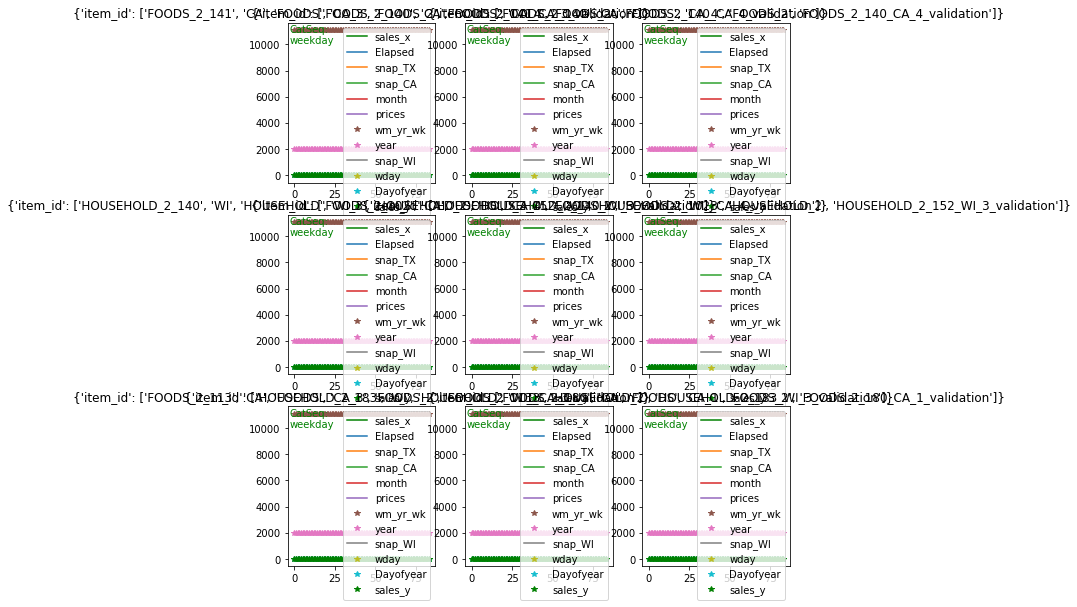

In [60]:
horizon,lookback = 28, 28*2
dls = MTSDataLoaders.from_m5_path(new_path, 'sales',  horizon=horizon, lookback=lookback, steps = 14,
                                  procs = [DateProc(new_path, 'date'), CatProc(new_path)])
dls.show_batch()

torch.Size([64, 12, 84])


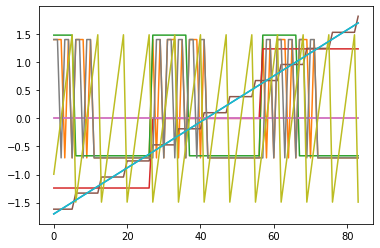

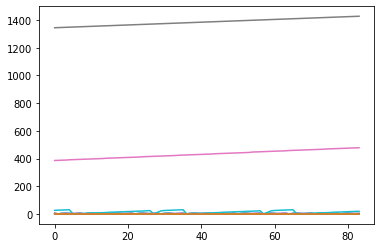

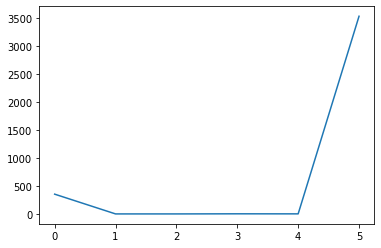

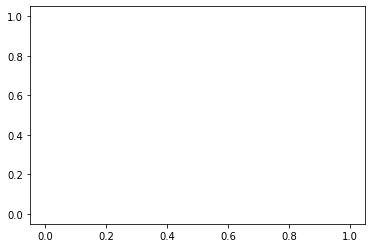

In [64]:
for o in dls.train:
    break
plt.plot(o[1][0].T.cpu()) # ts_con
plt.figure()
plt.plot(o[2][0].T.cpu(),) # ts_cat
print(o[2].shape)
plt.figure()
plt.plot(o[3][0].T.cpu(),) # cat
plt.figure()
plt.plot(o[4][0].T.cpu(),) # con


In [ ]:
# hide
from nbdev.export import *
notebook2script()

Converted 00_core.ipynb.
Converted 00_m5.ipynb.
Converted 01_data.external.ipynb.
Converted 02_data.load.ipynb.
Converted 03_data.core.ipynb.


In [118]:
git_add('04_data.procs.ipynb', commit_msg='CatProc')

Converted 04_data.procs.ipynb.


['/home/tako/dev/fastseq/fastseq/data/procs.py',
 '/home/tako/dev/fastseq/nbs/04_data.procs.ipynb']